In [1]:
import os
import pickle
import sys
from collections import Counter, defaultdict
from copy import deepcopy
from itertools import combinations
import pandas as pd
import json

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import powerlaw
from joblib import Parallel, delayed
from matplotlib import colors
from networkx.algorithms.community.quality import modularity as nx_modularity
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import f1_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.utils.testing import ignore_warnings
from tqdm.notebook import tqdm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

sys.path.append('../../pygkernels')
from pygkernels.measure import kernels
from pygkernels.scenario import d3_colors

/home/illusionww/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
class MyKNN:
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors
        
    def fit(self, X, y):
        self.X = X
        self.y = y
        
    def predict(self, X_test):
        output = []
        pair_distance = euclidean_distances(X_test, self.X)
        for test_idx in range(len(X_test)):
            chosen_indices = np.argsort(pair_distance[test_idx])[:self.n_neighbors]
            weighted_results = np.zeros(len(self.y[0]), dtype=np.float32)
            for chosen_idx in chosen_indices:
                weighted_results += self.y[chosen_idx]
            output.append(weighted_results)
        return np.array(output)
    

def euclidean_distances(X, Y):
    X, Y = np.array(X), np.array(Y)
    result = np.sqrt(np.sum(np.power(X[:, None] - Y[None, :], 2), axis=2))
    return result


class MyGaussianFilter:
    def __init__(self, sigma=0.05):
        self.sigma = sigma
        
    def fit(self, X, y):
        self.X = X
        self.y = y
        
    def predict(self, X_test):
        output = []
        pair_distance = euclidean_distances(X_test, self.X)
        gaussian_weights = np.exp(-np.power(pair_distance, 2) / (2 * self.sigma**2))
        for test_idx in range(len(X_test)):
            chosen_indices = []
            for train_idx in range(len(self.X)):
                if pair_distance[test_idx, train_idx] < 3 * self.sigma:
                    chosen_indices.append(train_idx)
            if len(chosen_indices) < 5:
                chosen_indices = []
            weighted_results = np.zeros(len(self.y[0]), dtype=np.float32)
            sum_weights = np.sum([gaussian_weights[test_idx, chosen_idx] for chosen_idx in chosen_indices])
            for chosen_idx in chosen_indices:
                weighted_results += gaussian_weights[test_idx, chosen_idx] * self.y[chosen_idx] / sum_weights
            output.append(weighted_results)
        return np.array(output)

In [3]:
def prepare_plot_knn(dataset, feature_names, n_neighbors=1):
    X = np.array([[feature_normalize(item['estimated_params'][fname], fname) for fname in feature_names] for item in dataset])
    y = np.array([sorted(item['measure_best_results'].items(), key=lambda x: -x[1])[0][0] for item in dataset])
    
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X, y)

    plot = np.zeros((resolution, resolution, 3), dtype=np.uint8)
    for xidx, xval in enumerate(np.linspace(0, 1, resolution)):
        for yidx, yval in enumerate(np.linspace(0, 1, resolution)):
            pixels_kernel_name = knn.predict([[xval, yval]])[0] 
            plot[xidx, yidx] = np.array(colors.to_rgb(d3_colors[pixels_kernel_name])) * 255
            
    return X, y, plot

def prepare_plot_filter(dataset, feature_names, distance=0.05):
    X = np.array([[feature_normalize(item['estimated_params'][fname], fname) for fname in feature_names] for item in dataset])
    y = np.array([[item['measure_best_results'][kernel] for kernel in kernels_order] for item in dataset])
    
    return prepare_plot_filter_internal(X, y, distance=distance)


def prepare_plot_filter_internal(X, y, distance=0.05):
    knn = MyGaussianFilter(sigma=distance)
    knn.fit(X, y)

    plot = np.zeros((resolution, resolution, 3), dtype=np.uint8)
    for xidx, xval in enumerate(np.linspace(0, 1, resolution)):
        for yidx, yval in enumerate(np.linspace(0, 1, resolution)):
            pixels_kernels_results = knn.predict([[xval, yval]])[0] 
            if ~np.all(pixels_kernels_results == 0):
                pixels_kernel_name = kernels_order[np.argmax(pixels_kernels_results)]
                plot[xidx, yidx] = np.array(colors.to_rgb(d3_colors[pixels_kernel_name])) * 255
            else:
                plot[xidx, yidx] = np.array([1, 1, 1]) * 255
            
    return X, y, plot

In [4]:
def point2plot(x, feature_name):
    vmin, vmax = 0, 1
    return (x - vmin) / (vmax - vmin) * resolution

def doplot(ax, X, y, plot, feature_names, scatter=True):
    ax.imshow(plot)
        
    n_ticks = 10 if feature_names[1] not in ['tau1', 'tau2'] else 2 
    ax.set_xticks(np.linspace(0, resolution, n_ticks))
    ax.set_xticklabels([f'{x:.2f}' for x in np.linspace(feature_min[feature_names[1]], feature_max[feature_names[1]], n_ticks)], rotation='vertical');
    ax.set_xlabel(feature_names[1])
    ax.set_xlim(0, resolution)
    
    n_ticks = 10 if feature_names[0] not in ['tau1', 'tau2'] else 2 
    ax.set_yticks(np.linspace(0, resolution, n_ticks))
    ax.set_yticklabels([f'{x:.2f}' for x in np.linspace(feature_min[feature_names[0]], feature_max[feature_names[0]], n_ticks)]);
    ax.set_ylabel(feature_names[0])
    ax.set_ylim(0, resolution)

    if scatter:
        ax.scatter([point2plot(x, feature_names[1]) for x in X[:, 1]], [point2plot(x, feature_names[0]) for x in X[:, 0]], s=1, c='black')

# LDA

In [5]:
kernels_order = [x.name for x in kernels]
list(enumerate(kernels_order))

[(0, 'Katz'),
 (1, 'logKatz'),
 (2, 'For'),
 (3, 'logFor'),
 (4, 'Comm'),
 (5, 'logComm'),
 (6, 'Heat'),
 (7, 'logHeat'),
 (8, 'NHeat'),
 (9, 'logNHeat'),
 (10, 'SCT'),
 (11, 'SCCT'),
 (12, 'RSP'),
 (13, 'FE'),
 (14, 'PPR'),
 (15, 'logPPR'),
 (16, 'ModifPPR'),
 (17, 'logModifPPR'),
 (18, 'HeatPR'),
 (19, 'logHeatPR'),
 (20, 'DF'),
 (21, 'logDF'),
 (22, 'Abs'),
 (23, 'logAbs'),
 (24, 'SP-CT')]

In [6]:
# root = '/media/illusionww/68949C3149F4E819/phd/pygkernels/montecarlo_lfr_simple'
# dataset = []
# for fn in tqdm(os.listdir(root)):
#     with open(f'{root}/{fn}', 'rb') as f:
#         dataset.append(json.load(f))

with open('filtered_dataset.json', 'r') as f:
    dataset = json.load(f)
len(dataset)

6681

In [7]:
to_drop = True
while to_drop:
    to_drop = False
    for idx in range(len(dataset)):
        if dataset[idx]['estimated_params']['sp_ari'] is None:
            to_drop = True
            del dataset[idx]
            break
len(dataset)

6677

In [8]:
to_drop = True
while to_drop:
    to_drop = False
    for idx in range(len(dataset)):
        if dataset[idx]['estimated_params']['ct_ari'] is None:
            to_drop = True
            del dataset[idx]
            break
len(dataset)

6674

In [9]:
fullset_feature_names = [
    'n',
    'k',
    'k|log',
    'k|inv',
    'tau1',
    'tau1|inv',
    'tau1|sqrtinv',
    'tau2',
    'tau2|inv',
    'tau2|sqrtinv',
    'mu',
    'min_density',
    'avg_density',
    'max_density',
    'min_degree',
    'min_degree|log',
    'avg_degree',
    'avg_degree|log',
    'max_degree',
    'max_degree|log',
    'min_community',
    'min_community|log',
    'avg_community',
    'avg_community|log',
    'max_community',
    'max_community|log',
    'min_community/n',
    'avg_community/n',
    'max_community/n',
    'maxari',
    'modularity',
    'mu/avg_density',
    'mu/avg_density|log',
    'sp_ari',
    'ct_ari'
]

all_feature_names = [
    'n',
    'k|inv',
    'tau1|inv',
    'tau2|inv',
    'mu',
    'min_density',
    'avg_density',
    'max_density',
    'min_degree|log',
    'avg_degree|log',
    'max_degree|log',
    'min_community|log',
    'avg_community|log',
    'max_community|log',
    'min_community/n',
#     'avg_community/n',
    'max_community/n',
    'maxari',
    'modularity',
    'mu/avg_density|log',
    'sp_ari',
    'ct_ari'
]

shortlist = [
    'k|inv',
    'tau1|inv',
    'mu',
    'min_density',
    'avg_density',
    'max_density',
    'min_community/n',
    'avg_community/n',
    'max_community/n',
#     'maxari',
    'modularity',
    'sp_ari',
    'ct_ari'
]

feature_min = {fn: np.min([data['estimated_params'][fn] for data in dataset]) for fn in fullset_feature_names}
feature_max = {fn: np.max([data['estimated_params'][fn] for data in dataset]) for fn in fullset_feature_names}
feature_width = {fn: feature_max[fn] - feature_min[fn] for fn in fullset_feature_names}
feature_normalize = lambda x, fn: (x - feature_min[fn]) / feature_width[fn]

for fn in fullset_feature_names:
    print(f'{fn}: {feature_min[fn]:.2f}, {feature_max[fn]:.2f} | '
          f'{feature_normalize(feature_min[fn], fn):.2f}, {feature_normalize(feature_max[fn], fn):.2f}')

n: 10.00, 1499.00 | 0.00, 1.00
k: 2.00, 147.00 | 0.00, 1.00
k|log: 0.69, 4.99 | 0.00, 1.00
k|inv: 0.50, 0.99 | 0.00, 1.00
tau1: 1.87, 390.09 | 0.00, 1.00
tau1|inv: 0.47, 1.00 | 0.00, 1.00
tau1|sqrtinv: 0.27, 0.95 | 0.00, 1.00
tau2: 1.51, 1440.00 | 0.00, 1.00
tau2|inv: 0.34, 1.00 | 0.00, 1.00
tau2|sqrtinv: 0.19, 0.97 | 0.00, 1.00
mu: 0.00, 1.00 | 0.00, 1.00
min_density: 0.00, 0.77 | 0.00, 1.00
avg_density: 0.00, 0.88 | 0.00, 1.00
max_density: 0.02, 1.07 | 0.00, 1.00
min_degree: 1.00, 988.00 | 0.00, 1.00
min_degree|log: 0.00, 6.90 | 0.00, 1.00
avg_degree: 2.36, 1174.29 | 0.00, 1.00
avg_degree|log: 0.86, 7.07 | 0.00, 1.00
max_degree: 4.00, 1467.00 | 0.00, 1.00
max_degree|log: 1.39, 7.29 | 0.00, 1.00
min_community: 1.00, 742.00 | 0.00, 1.00
min_community|log: 0.00, 6.61 | 0.00, 1.00
avg_community: 1.09, 749.50 | 0.00, 1.00
avg_community|log: 0.09, 6.62 | 0.00, 1.00
max_community: 2.00, 1294.00 | 0.00, 1.00
max_community|log: 0.69, 7.17 | 0.00, 1.00
min_community/n: 0.00, 0.50 | 0.00, 1.00


In [10]:
resolution = 100

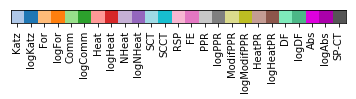

In [11]:
def draw_legend():
    a = np.zeros((1, 25, 3), dtype=np.uint8)
    labels = []
    for idx, kernel in enumerate(kernels):
        a[0, idx] = np.array(colors.to_rgb(d3_colors[kernel.name])) * 255
        labels.append(kernel.name)
    plt.imshow(a)
    plt.xticks(range(25), labels, rotation='vertical')
    plt.yticks([])
    plt.plot()
    
draw_legend()

In [12]:
dataset_wo_le = []
for item in dataset:
    aris = np.array(list(item['measure_best_results'].values()))
    if np.sum(np.max(aris) == aris) == 1:
        dataset_wo_le.append(item)

## Full feature set

(4883, 35) (4883, 25)


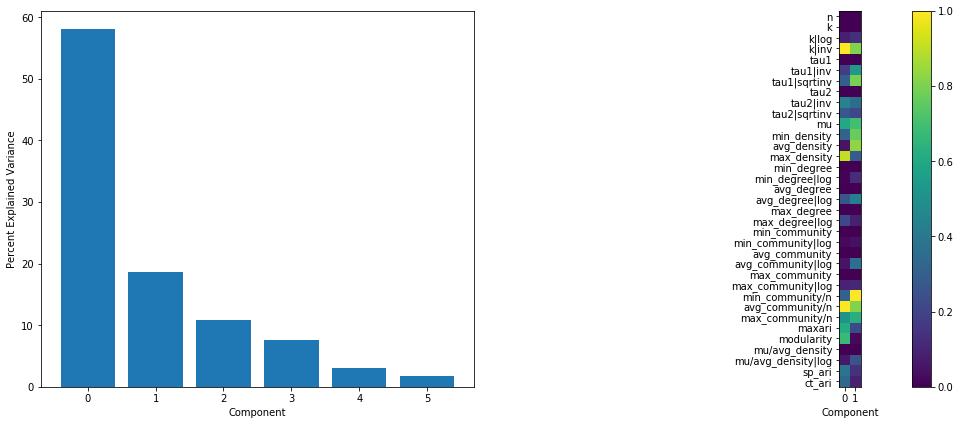

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

X_full = np.array([[item['estimated_params'][fname] for fname in fullset_feature_names] for item in dataset_wo_le])
y = np.array([[item['measure_best_results'][kname] for kname in kernels_order] for item in dataset_wo_le])
print(X_full.shape, y.shape)

y_filtered = y.copy()
for idx, kernel_name in enumerate(kernels_order):
    if kernel_name not in ['SCCT', 'NHeat', 'logComm', 'logDF', 'RSP', 'Comm', 'SCT']:
        y_filtered[:, idx] = 0

pca = LinearDiscriminantAnalysis(n_components=None)
pca.fit(X_full, np.argmax(y_filtered, axis=1))
ax[0].bar(range(len(pca.explained_variance_ratio_)), np.array(pca.explained_variance_ratio_) * 100)
ax[0].set_xlabel('Component')
ax[0].set_ylabel('Percent Explained Variance')

pca = LinearDiscriminantAnalysis(n_components=2)
pca.fit(X_full, np.argmax(y_filtered, axis=1))
img = np.abs(pca.transform(np.eye(len(fullset_feature_names))) - pca.transform(np.zeros((1, len(fullset_feature_names)))))
img = (img - np.min(img, axis=0, keepdims=True)) / (np.max(img, axis=0, keepdims=True) - np.min(img, axis=0, keepdims=True))
ia = ax[1].imshow(img)
ax[1].set_xticks(range(0, 2))
ax[1].set_yticks(range(len(fullset_feature_names)));
ax[1].set_yticklabels(fullset_feature_names)
ax[1].set_xlabel('Component')

plt.tight_layout()
fig.colorbar(ia, ax=ax);

# 2d

(4883, 21) (4883, 25)


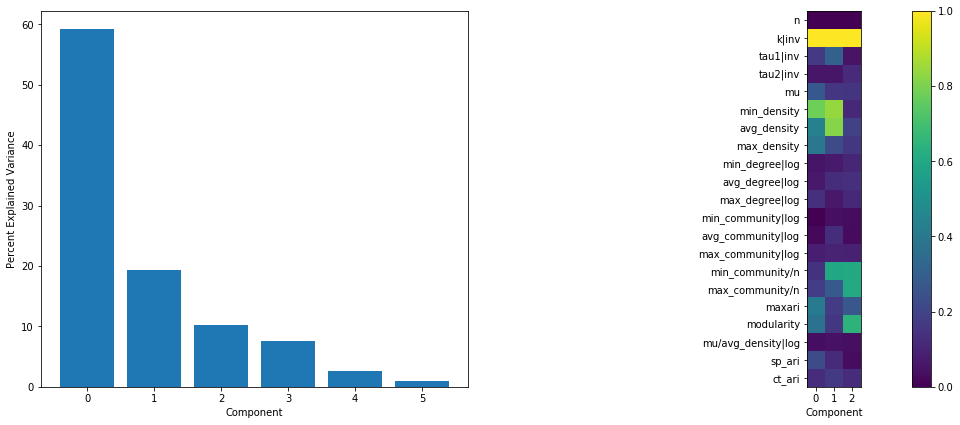

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

X_all = np.array([[item['estimated_params'][fname] for fname in all_feature_names] for item in dataset_wo_le])
y = np.array([[item['measure_best_results'][kname] for kname in kernels_order] for item in dataset_wo_le])
print(X_all.shape, y.shape)

y_filtered = y.copy()
for idx, kernel_name in enumerate(kernels_order):
    if kernel_name not in ['SCCT', 'NHeat', 'logComm', 'logDF', 'RSP', 'Comm', 'SCT']:
        y_filtered[:, idx] = 0

pca = LinearDiscriminantAnalysis(n_components=None)
X_new = pca.fit_transform(X_all, np.argmax(y_filtered, axis=1))
ax[0].bar(range(len(pca.explained_variance_ratio_)), np.array(pca.explained_variance_ratio_) * 100)
ax[0].set_xlabel('Component')
ax[0].set_ylabel('Percent Explained Variance')

pca = LinearDiscriminantAnalysis(n_components=3)
X_new = pca.fit_transform(X_all, np.argmax(y_filtered, axis=1))
img = np.abs(pca.transform(np.eye(len(all_feature_names))) - pca.transform(np.zeros((1, len(all_feature_names)))))
img = (img - np.min(img, axis=0, keepdims=True)) / (np.max(img, axis=0, keepdims=True) - np.min(img, axis=0, keepdims=True))
ia = ax[1].imshow(img)
ax[1].set_xticks(range(0, 3))
ax[1].set_yticks(range(len(all_feature_names)));
ax[1].set_yticklabels(all_feature_names)
ax[1].set_xlabel('Component')

plt.tight_layout()
fig.colorbar(ia, ax=ax);

In [15]:
feature_min['comp1'] = np.min(X_new[:, 0])
feature_max['comp1'] = np.max(X_new[:, 0])
feature_width['comp1'] = feature_max['comp1'] - feature_min['comp1']

feature_min['comp2'] = np.min(X_new[:, 1])
feature_max['comp2'] = np.max(X_new[:, 1])
feature_width['comp2'] = feature_max['comp2'] - feature_min['comp2']

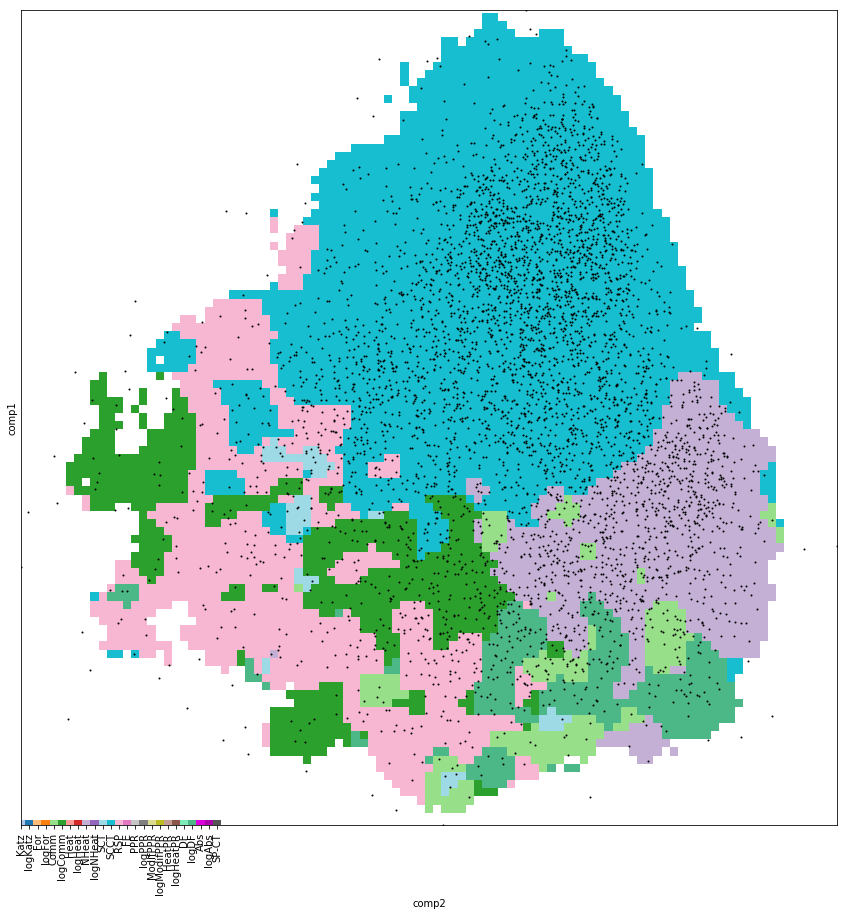

In [16]:
distance = 0.015

fig, ax = plt.subplots(1, 1, figsize=(15, 15))

X_normalized = X_new[:, :2].copy()
X_normalized_min = np.min(X_normalized, axis=0)
X_normalized_max = np.max(X_normalized, axis=0)
X_normalized_width = X_normalized_max - X_normalized_min

X_normalized = (X_normalized - X_normalized_min[None]) / X_normalized_width[None]


feature_names = ['comp1', 'comp2']
X, y, plot = prepare_plot_filter_internal(X_normalized, y_filtered, distance=distance)
doplot(ax, X, y_filtered, plot, feature_names)

plt.plot()
draw_legend()

# 2d: shortlist

(4883, 12) (4883, 25)


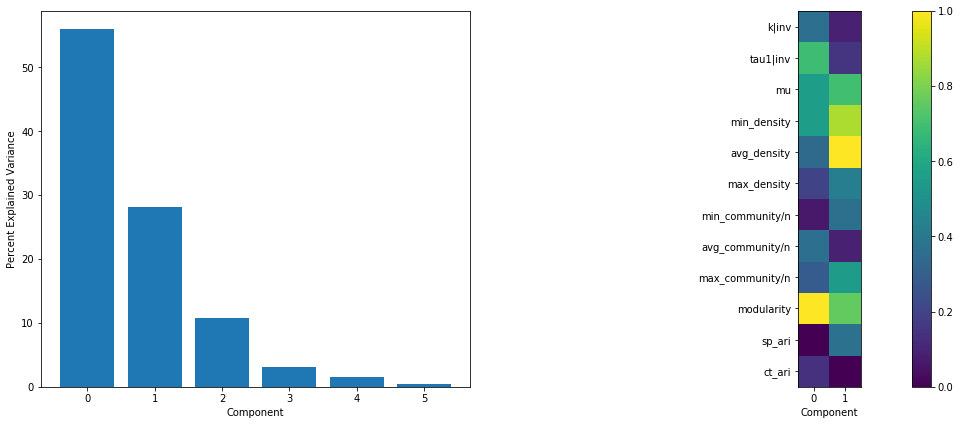

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

X_all = np.array([[item['estimated_params'][fname] for fname in shortlist] for item in dataset_wo_le])
y = np.array([[item['measure_best_results'][kname] for kname in kernels_order] for item in dataset_wo_le])
print(X_all.shape, y.shape)

y_filtered = y.copy()
for idx, kernel_name in enumerate(kernels_order):
    if kernel_name not in ['SCCT', 'NHeat', 'logComm', 'logDF', 'RSP', 'Comm', 'SCT']:
        y_filtered[:, idx] = 0

pca = LinearDiscriminantAnalysis(n_components=None)
pca.fit_transform(X_all, np.argmax(y_filtered, axis=1))
ax[0].bar(range(len(pca.explained_variance_ratio_)), np.array(pca.explained_variance_ratio_) * 100)
ax[0].set_xlabel('Component')
ax[0].set_ylabel('Percent Explained Variance')

pca = LinearDiscriminantAnalysis(n_components=2)
X_new = pca.fit_transform(X_all, np.argmax(y_filtered, axis=1))
img = np.abs(pca.transform(np.eye(len(shortlist))) - pca.transform(np.zeros((1, len(shortlist)))))
img = (img - np.min(img, axis=0, keepdims=True)) / (np.max(img, axis=0, keepdims=True) - np.min(img, axis=0, keepdims=True))
ia = ax[1].imshow(img)
ax[1].set_xticks(range(0, 2))
ax[1].set_yticks(range(len(shortlist)));
ax[1].set_yticklabels(shortlist)
ax[1].set_xlabel('Component')

plt.tight_layout()
fig.colorbar(ia, ax=ax);

In [18]:
feature_min['comp1'] = np.min(X_new[:, 0])
feature_max['comp1'] = np.max(X_new[:, 0])
feature_width['comp1'] = feature_max['comp1'] - feature_min['comp1']

feature_min['comp2'] = np.min(X_new[:, 1])
feature_max['comp2'] = np.max(X_new[:, 1])
feature_width['comp2'] = feature_max['comp2'] - feature_min['comp2']

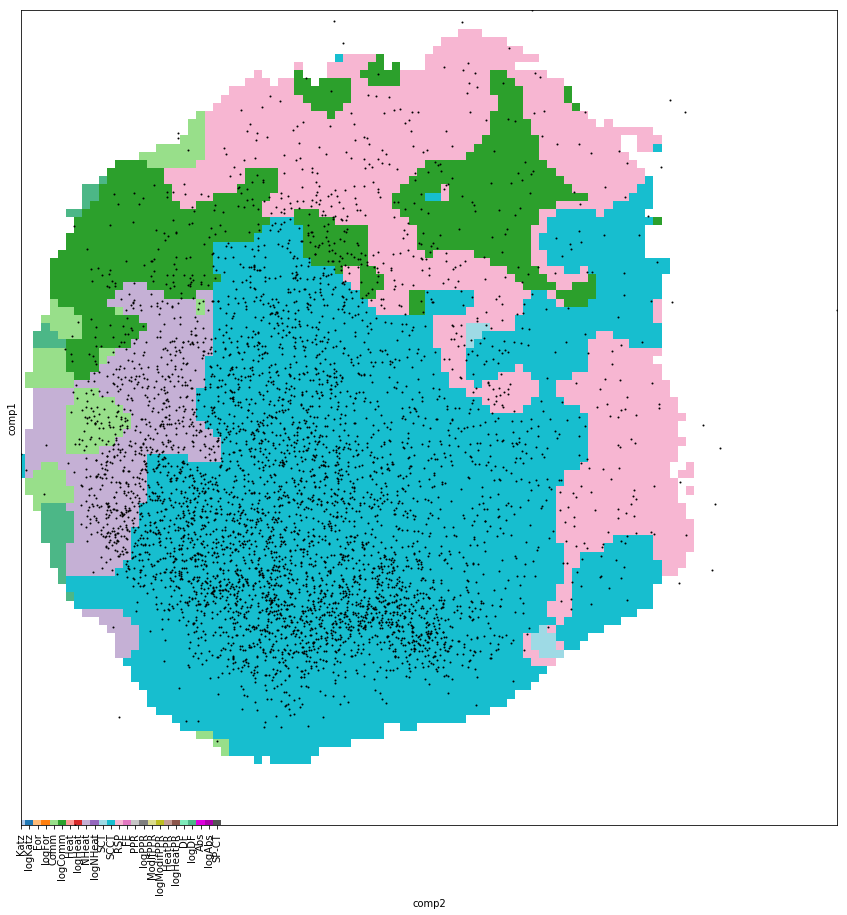

In [19]:
distance = 0.02
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

X_normalized = X_new[:, :2].copy()
X_normalized_min = np.min(X_normalized, axis=0)
X_normalized_max = np.max(X_normalized, axis=0)
X_normalized_width = X_normalized_max - X_normalized_min

X_normalized = (X_normalized - X_normalized_min[None]) / X_normalized_width[None]

feature_names = ['comp1', 'comp2']
X, y, plot = prepare_plot_filter_internal(X_normalized, y_filtered, distance=distance)
doplot(ax, X, y_filtered, plot, feature_names)

plt.plot()
draw_legend()